## Notebook 2 : Geographical vizualizations and regional comparisons

## 1 - Introduction ##

Overview of the notebook’s objective and the data used.


In [1]:
#### EXPLORING THE DATASET ####
import pandas as pd

# Read in the data
df_geo = pd.read_csv('df_complete.csv')

df_geo.head()

/var/folders/ql/7rnwb81s5ms8q8f6v8hbbkb00000gn/T/ipykernel_1078/325737377.py:5: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df_geo = pd.read_csv('df_complete.csv')


,Date mutation,Nature mutation,Valeur fonciere,Voie,Code postal,Commune,Code departement,Code commune,Nombre de lots,Code type local,Type local,Surface reelle bati,Nombre pieces principales,Surface terrain,annee
0,2019-01-07 00:00:00.000000000,Vente,244200.0,COMMANDANT COUSTEAU,1000.0,BOURG-EN-BRESSE,1,53,0,1.0,Maison,150.0,5.0,695.0,2019
1,2019-04-07 00:00:00.000000000,Vente,195000.0,DE LA CROIX ROSIER,1250.0,HAUTECOURT-ROMANECHE,1,184,0,1.0,Maison,94.0,4.0,888.0,2019
2,2019-04-07 00:00:00.000000000,Vente,195000.0,DE LA CROIX ROSIER,1250.0,HAUTECOURT-ROMANECHE,1,184,0,1.0,Maison,94.0,4.0,500.0,2019
3,2019-04-07 00:00:00.000000000,Vente,110030.0,LA VILLE,1250.0,GRAND-CORENT,1,177,0,1.0,Maison,90.0,3.0,522.0,2019
4,2019-03-07 00:00:00.000000000,Vente,160450.0,CHARBONNET,1270.0,COLIGNY,1,108,0,0.0,0,0.0,0.0,8.0,2019


In [2]:
#### CONVERTS TO THE RIGHT TYPE ####

category_convert = ['Nature mutation', 'Voie', 'Code postal', 'Commune', 'Code departement', 'Code commune', 'Code type local', 'Type local']
df_geo[category_convert] = df_geo[category_convert].astype('category')

df_geo['Date mutation'] = pd.to_datetime(df_geo['Date mutation'], errors = 'coerce')
df_geo['Date mutation'] = df_geo['Date mutation'].interpolate(method='linear')

df_geo['Valeur fonciere']=df_geo['Valeur fonciere'].replace({'\xa0':'',',':'.'}, regex=True)
df_geo['Valeur fonciere']=pd.to_numeric(df_geo['Valeur fonciere'], errors='coerce')

df_geo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17810875 entries, 0 to 17810874
Data columns (total 15 columns):
 #   Column                     Dtype         
---  ------                     -----         
 0   Date mutation              datetime64[ns]
 1   Nature mutation            category      
 2   Valeur fonciere            float64       
 3   Voie                       category      
 4   Code postal                category      
 5   Commune                    category      
 6   Code departement           category      
 7   Code commune               category      
 8   Nombre de lots             int64         
 9   Code type local            category      
 10  Type local                 category      
 11  Surface reelle bati        float64       
 12  Nombre pieces principales  float64       
 13  Surface terrain            float64       
 14  annee                      int64         
dtypes: category(8), datetime64[ns](1), float64(4), int64(2)
memory usage: 1.2 GB


In [3]:
#### CHECK MISSING VALUES ####
df_geo.isnull().sum()

Date mutation                0
Nature mutation              0
Valeur fonciere              0
Voie                         0
Code postal                  0
Commune                      0
Code departement             0
Code commune                 0
Nombre de lots               0
Code type local              0
Type local                   0
Surface reelle bati          0
Nombre pieces principales    0
Surface terrain              0
annee                        0
dtype: int64

In [4]:
#### CHECK DUPLICATES ####
#df_geo.drop_duplicates(keep='last', inplace=True)
df_geo.duplicated().sum()

0

In [5]:
df_geo.head()

,Date mutation,Nature mutation,Valeur fonciere,Voie,Code postal,Commune,Code departement,Code commune,Nombre de lots,Code type local,Type local,Surface reelle bati,Nombre pieces principales,Surface terrain,annee
0,2019-01-07,Vente,244200.0,COMMANDANT COUSTEAU,1000.0,BOURG-EN-BRESSE,1,53,0,1.0,Maison,150.0,5.0,695.0,2019
1,2019-04-07,Vente,195000.0,DE LA CROIX ROSIER,1250.0,HAUTECOURT-ROMANECHE,1,184,0,1.0,Maison,94.0,4.0,888.0,2019
2,2019-04-07,Vente,195000.0,DE LA CROIX ROSIER,1250.0,HAUTECOURT-ROMANECHE,1,184,0,1.0,Maison,94.0,4.0,500.0,2019
3,2019-04-07,Vente,110030.0,LA VILLE,1250.0,GRAND-CORENT,1,177,0,1.0,Maison,90.0,3.0,522.0,2019
4,2019-03-07,Vente,160450.0,CHARBONNET,1270.0,COLIGNY,1,108,0,0.0,0,0.0,0.0,8.0,2019


## 2 - Methodology ##

Explanation of the analysis methods and visualizations.

Data Exploration:
- Analyze geographical data (communes, departments) and its relationship to property values.
- Study temporal trends in transactions across regions.

In [6]:
#### LIBRARIES ####
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import ipywidgets as widgets
from IPython.display import display

In [7]:
#### PRICE PER SQUARE METER ####
df_geo['price_per_sq_meter'] = df_geo['Valeur fonciere'] / df_geo['Surface reelle bati']
df_geo['price_per_sq_meter'] = df_geo['price_per_sq_meter'].round(2)
df_geo.head()

,Date mutation,Nature mutation,Valeur fonciere,Voie,Code postal,Commune,Code departement,Code commune,Nombre de lots,Code type local,Type local,Surface reelle bati,Nombre pieces principales,Surface terrain,annee,price_per_sq_meter
0,2019-01-07,Vente,244200.0,COMMANDANT COUSTEAU,1000.0,BOURG-EN-BRESSE,1,53,0,1.0,Maison,150.0,5.0,695.0,2019,1628.00
1,2019-04-07,Vente,195000.0,DE LA CROIX ROSIER,1250.0,HAUTECOURT-ROMANECHE,1,184,0,1.0,Maison,94.0,4.0,888.0,2019,2074.47
2,2019-04-07,Vente,195000.0,DE LA CROIX ROSIER,1250.0,HAUTECOURT-ROMANECHE,1,184,0,1.0,Maison,94.0,4.0,500.0,2019,2074.47
3,2019-04-07,Vente,110030.0,LA VILLE,1250.0,GRAND-CORENT,1,177,0,1.0,Maison,90.0,3.0,522.0,2019,1222.56
4,2019-03-07,Vente,160450.0,CHARBONNET,1270.0,COLIGNY,1,108,0,0.0,0,0.0,0.0,8.0,2019,inf


In [8]:
#### ANALISYS OF WHEN THERE'S NO BUILD ####
df_no_build = df_geo[df_geo['Surface reelle bati']==0]
mean_no_build = round(df_no_build['Valeur fonciere'].mean(), 2)
median_no_build = round(df_no_build['Valeur fonciere'].median(), 2)

print('No build average price per square meter : ', mean_no_build, '€')
print('No build median price per square meter : ', median_no_build, '€')

df_build = df_geo[df_geo['Surface reelle bati']!=0]
mean_build = round(df_build['Valeur fonciere'].mean(), 2)
median_build = round(df_build['Valeur fonciere'].median(), 2)

print('\nBuild average price per square meter : ', mean_build, '€')
print('Build median price per square meter : ', median_build, '€')

No build average price per square meter :  385543.11 €
No build median price per square meter :  120000.0 €

Build average price per square meter :  885459.29 €
Build median price per square meter :  191900.0 €


In [9]:
#### PLOT NO BUILD / BUILT TERRAIN PRICE ####

colors = px.colors.qualitative.Pastel

# Data
categories = ['No Build Terrain', 'Built Terrain']
mean_values = [mean_no_build, mean_build]
median_values = [median_no_build, median_build]

# Create subplots
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=("Mean", "Median"),
    specs=[[{"type": "xy"}, {"type": "xy"}]]
)

# Outliers
fig.add_trace(
    go.Bar(
    y = mean_values,
    x = categories,
    name = 'Maen',
    marker = dict(color = colors[5]),
    ),
    row=1, col=1
)

# Non-outliers
fig.add_trace(
    go.Bar(
        y = median_values,
        x = categories,
        name = 'Mean',
        marker = dict(color = colors[3]),
    ),
    row=1, col=2
)

fig.update_layout(
    title_text="Comparison between no build terrains and built terrains prices",
    xaxis_title="Terrain Type",
    xaxis2_title="Terrain Type",
    yaxis_title="Property Value (€)",
    showlegend=False,
    yaxis2=dict(range=[0, 900000])
)
fig.show()

In [10]:
#### DELETE THE INF (NO BUILD) ####
df_geo['price_per_sq_meter'] = df_geo['price_per_sq_meter'].replace([np.inf, -np.inf], np.nan)
df_geo.dropna(subset=['price_per_sq_meter'], inplace=True)
df_geo.head()

,Date mutation,Nature mutation,Valeur fonciere,Voie,Code postal,Commune,Code departement,Code commune,Nombre de lots,Code type local,Type local,Surface reelle bati,Nombre pieces principales,Surface terrain,annee,price_per_sq_meter
0,2019-01-07,Vente,244200.0,COMMANDANT COUSTEAU,1000.0,BOURG-EN-BRESSE,1,53,0,1.0,Maison,150.0,5.0,695.0,2019,1628.00
1,2019-04-07,Vente,195000.0,DE LA CROIX ROSIER,1250.0,HAUTECOURT-ROMANECHE,1,184,0,1.0,Maison,94.0,4.0,888.0,2019,2074.47
2,2019-04-07,Vente,195000.0,DE LA CROIX ROSIER,1250.0,HAUTECOURT-ROMANECHE,1,184,0,1.0,Maison,94.0,4.0,500.0,2019,2074.47
3,2019-04-07,Vente,110030.0,LA VILLE,1250.0,GRAND-CORENT,1,177,0,1.0,Maison,90.0,3.0,522.0,2019,1222.56
5,2019-03-07,Vente,160450.0,CHARBONNET,1270.0,COLIGNY,1,108,0,1.0,Maison,110.0,5.0,2483.0,2019,1458.64


In [11]:
df_geo.isnull().sum()

Date mutation                0
Nature mutation              0
Valeur fonciere              0
Voie                         0
Code postal                  0
Commune                      0
Code departement             0
Code commune                 0
Nombre de lots               0
Code type local              0
Type local                   0
Surface reelle bati          0
Nombre pieces principales    0
Surface terrain              0
annee                        0
price_per_sq_meter           0
dtype: int64

In [12]:
#### GROUPING DATA BY DEPARTMENT AND COMMUNE + METRICS CALCULUS ####
grouped_geo = df_geo.groupby(['Code departement', 'Commune', 'annee', 'Type local', 'Surface terrain'], observed=True).agg(
    mean_value=('Valeur fonciere', 'mean'),
    median_value=('Valeur fonciere', 'median'),
    sum_value=('Valeur fonciere', 'sum'),
    count_transactions=('Valeur fonciere', 'count'),
    avg_price_per_sq_meter=('price_per_sq_meter', 'mean')
).reset_index()

grouped_geo.head()

,Code departement,Commune,annee,Type local,Surface terrain,mean_value,median_value,sum_value,count_transactions,avg_price_per_sq_meter
0,1,ABERGEMENT-DE-VAREY (L ),2019,Maison,135.0,103650.0,103650.0,103650.0,1,2073.00
1,1,ABERGEMENT-DE-VAREY (L ),2019,Maison,390.0,102000.0,102000.0,102000.0,1,850.00
2,1,ABERGEMENT-DE-VAREY (L ),2019,Maison,408.0,70000.0,70000.0,70000.0,1,933.33
3,1,ABERGEMENT-DE-VAREY (L ),2019,Maison,647.0,304800.0,304800.0,304800.0,1,1319.48
4,1,ABERGEMENT-DE-VAREY (L ),2019,Maison,757.0,163000.0,163000.0,163000.0,1,1164.29


In [13]:
grouped_geo.isnull().sum()

Code departement          0
Commune                   0
annee                     0
Type local                0
Surface terrain           0
mean_value                0
median_value              0
sum_value                 0
count_transactions        0
avg_price_per_sq_meter    0
dtype: int64

In [14]:
grouped_geo.describe()

,annee,Surface terrain,mean_value,median_value,sum_value,count_transactions,avg_price_per_sq_meter
count,3.393312e+06,3.393312e+06,3.393312e+06,3.393312e+06,3.393312e+06,3.393312e+06,3.393312e+06
mean,2.021346e+03,9.781057e+02,4.939329e+05,4.923398e+05,1.764431e+06,1.992674e+00,6.049800e+03
std,1.444690e+00,5.503172e+03,9.906512e+06,9.924518e+06,8.086412e+07,2.841723e+01,1.081583e+05
min,2.019000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00
25%,2.020000e+03,2.420000e+02,1.196000e+05,1.190000e+05,1.250000e+05,1.000000e+00,1.272730e+03
50%,2.021000e+03,5.050000e+02,1.950000e+05,1.950000e+05,2.147000e+05,1.000000e+00,2.016300e+03
75%,2.022000e+03,8.980000e+02,3.140000e+05,3.125000e+05,3.683000e+05,1.000000e+00,3.157890e+03
max,2.024000e+03,3.760000e+06,1.415000e+10,1.415000e+10,7.971528e+10,9.630000e+03,2.810003e+07


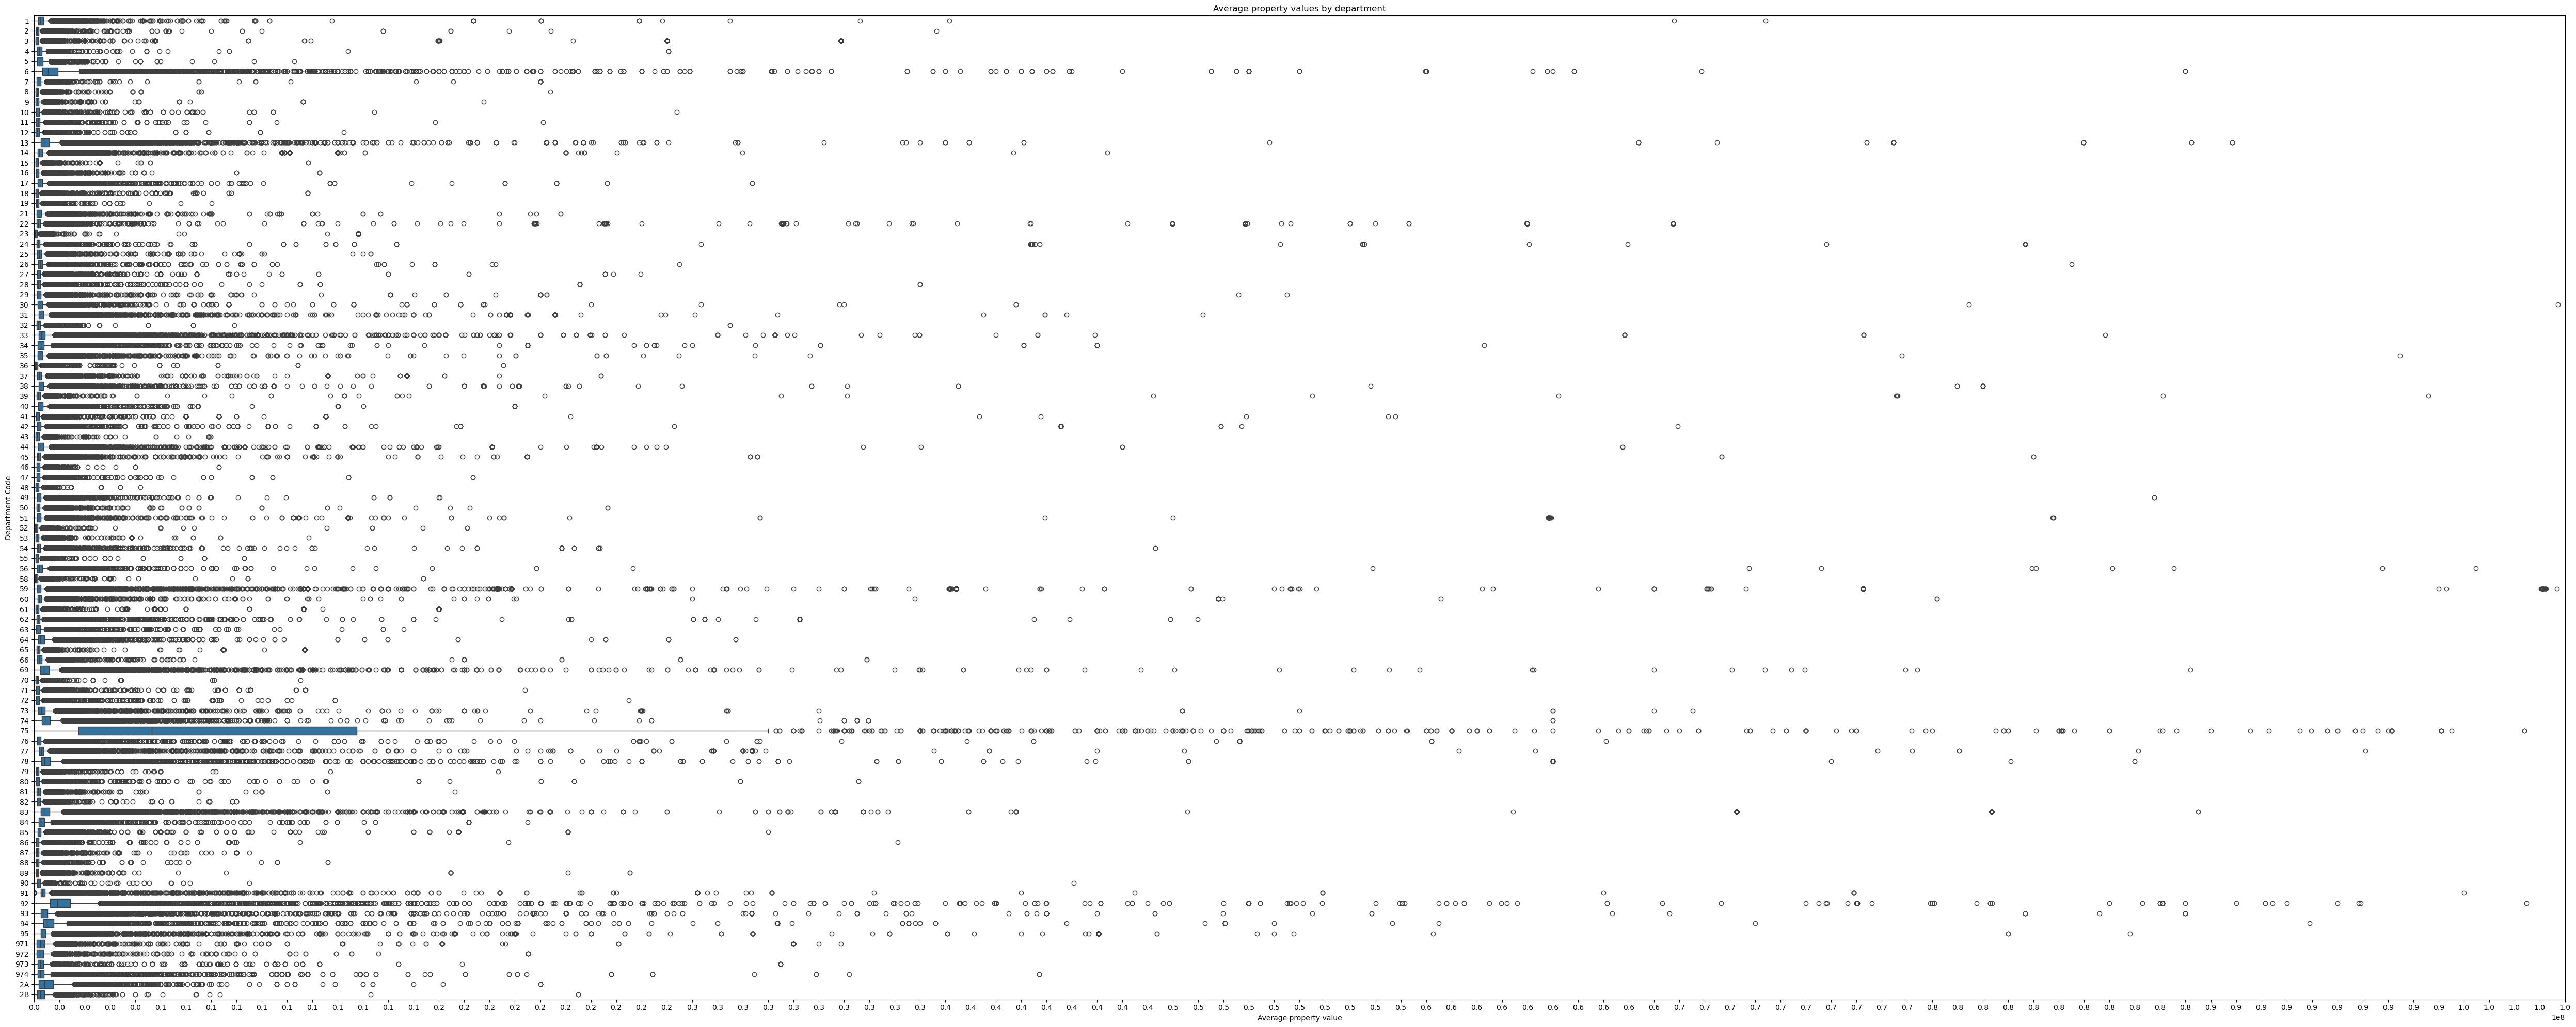

In [15]:
#### IDENTIFY OUTLIERS ####
plt.figure(figsize=(50, 20))
sns.boxplot(data=grouped_geo, x='mean_value', y='Code departement')

plt.title('Average property values by department')
plt.xlabel('Average property value')
plt.ylabel('Department Code')
x_ticks = np.arange(0, grouped_geo['mean_value'].max(), step=1000000)
plt.xticks(x_ticks)
plt.xlim(-10, 100000000)
plt.tight_layout()

plt.show()

There are a lot of outliers , this can be explained because of the type of local sold, the year they were sold (inflation ?), their size or their localization. Let's analyze that.

In [16]:
#### SEPARATE OUTLIERS WITH IQR ####
Q1 = df_geo['Valeur fonciere'].quantile(0.25)
Q3 = df_geo['Valeur fonciere'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df_geo[(df_geo['Valeur fonciere'] < lower_bound) | (df_geo['Valeur fonciere'] > upper_bound)]
non_outliers = df_geo[(df_geo['Valeur fonciere'] >= lower_bound) & (df_geo['Valeur fonciere'] <= upper_bound)]

outliers.head()

,Date mutation,Nature mutation,Valeur fonciere,Voie,Code postal,Commune,Code departement,Code commune,Nombre de lots,Code type local,Type local,Surface reelle bati,Nombre pieces principales,Surface terrain,annee,price_per_sq_meter
117,2019-03-07 00:00:00.000000000,Vente,3000000.0,MARECHAL JUIN,1000.0,BOURG-EN-BRESSE,1,53,0,4.0,Local industriel. commercial ou assimilé,2465.0,0.0,5926.0,2019,1217.04
1813,2019-08-14 08:43:38.181818112,Vente,644100.0,DU PLAN D'EAU,1370.0,VAL-REVERMONT,1,426,0,4.0,Local industriel. commercial ou assimilé,2191.0,0.0,5247.0,2019,293.98
1814,2019-07-31 10:54:32.727272704,Vente,644100.0,DU PLAN D'EAU,1370.0,VAL-REVERMONT,1,426,0,4.0,Local industriel. commercial ou assimilé,2191.0,0.0,5000.0,2019,293.98
2564,2019-06-11 00:00:00.000000000,Vente,720000.0,DU 1ER SEPTEMBRE 1944,1160.0,PONT-D AIN,1,304,0,4.0,Local industriel. commercial ou assimilé,438.0,0.0,273.0,2019,1643.84
2565,2019-07-11 09:36:00.000000000,Vente,720000.0,DU 1ER SEPTEMBRE 1944,1160.0,PONT-D AIN,1,304,0,4.0,Local industriel. commercial ou assimilé,782.0,0.0,559.0,2019,920.72


We see that a lot of them are commercial or industrial locals which could explain why they are expensive.

In [17]:
#### GROUPING OUTLIERS BY DEPARTMENT AND COMMUNE ####
grouped_outliers = outliers.groupby(['Code departement', 'Commune', 'annee', 'Type local', 'Surface terrain'], observed=True).agg(
    mean_outliers_value=('Valeur fonciere', 'mean'),
    median_outliers_value=('Valeur fonciere', 'median'),
    sum_outliers_value=('Valeur fonciere', 'sum'),
    count_outliers_transactions=('Valeur fonciere', 'count'),
    outliers_avg_price_per_sq_meter=('price_per_sq_meter', 'mean')
).reset_index()

grouped_outliers.head()

,Code departement,Commune,annee,Type local,Surface terrain,mean_outliers_value,median_outliers_value,sum_outliers_value,count_outliers_transactions,outliers_avg_price_per_sq_meter
0,1,AMBERIEU-EN-BUGEY,2019,Local industriel. commercial ou assimilé,0.0,1375200.0,1375200.0,1375200.0,1,9550.00
1,1,AMBERIEU-EN-BUGEY,2019,Local industriel. commercial ou assimilé,4590.0,886935.0,886935.0,886935.0,1,684.89
2,1,AMBERIEU-EN-BUGEY,2019,Local industriel. commercial ou assimilé,6388.0,1475000.0,1475000.0,1475000.0,1,368.75
3,1,AMBERIEU-EN-BUGEY,2019,Maison,128.0,5692688.5,5692688.5,5692688.5,1,50377.77
4,1,AMBERIEU-EN-BUGEY,2020,Local industriel. commercial ou assimilé,2000.0,1300000.0,1300000.0,1300000.0,1,236.36


In [18]:
grouped_outliers.isnull().sum()

Code departement                   0
Commune                            0
annee                              0
Type local                         0
Surface terrain                    0
mean_outliers_value                0
median_outliers_value              0
sum_outliers_value                 0
count_outliers_transactions        0
outliers_avg_price_per_sq_meter    0
dtype: int64

In [46]:
#### GROUPING NON-OUTLIERS BY DEPARTMENT AND COMMUNE ####
grouped_non_outliers = non_outliers.groupby(['Code departement', 'Commune', 'annee', 'Type local', 'Surface terrain'], observed=True).agg(
    mean_outliers_value=('Valeur fonciere', 'mean'),
    median_outliers_value=('Valeur fonciere', 'median'),
    sum_outliers_value=('Valeur fonciere', 'sum'),
    count_non_outliers_transactions=('Valeur fonciere', 'count'),
    non_outliers_avg_price_per_sq_meter=('price_per_sq_meter', 'mean')
).reset_index()

grouped_non_outliers.head()

,Code departement,Commune,annee,Type local,Surface terrain,mean_outliers_value,median_outliers_value,sum_outliers_value,count_non_outliers_transactions,non_outliers_avg_price_per_sq_meter
0,1,ABERGEMENT-DE-VAREY (L ),2019,Maison,135.0,103650.0,103650.0,103650.0,1,2073.00
1,1,ABERGEMENT-DE-VAREY (L ),2019,Maison,390.0,102000.0,102000.0,102000.0,1,850.00
2,1,ABERGEMENT-DE-VAREY (L ),2019,Maison,408.0,70000.0,70000.0,70000.0,1,933.33
3,1,ABERGEMENT-DE-VAREY (L ),2019,Maison,647.0,304800.0,304800.0,304800.0,1,1319.48
4,1,ABERGEMENT-DE-VAREY (L ),2019,Maison,757.0,163000.0,163000.0,163000.0,1,1164.29


In [47]:
#### METRICS COMPARISON ####

# All
mean_all = df_geo['Valeur fonciere'].mean()
median_all = df_geo['Valeur fonciere'].median()

# Non-outliers
mean_non_outliers = non_outliers['Valeur fonciere'].mean()
median_non_outliers = non_outliers['Valeur fonciere'].median()

# Outliers
mean_outliers = outliers['Valeur fonciere'].mean()
median_outliers = outliers['Valeur fonciere'].median()

print("General mean :", mean_all)
print("General median :", median_all)
print("\nNon-outliers mean :", mean_non_outliers)
print("Non-outliers median :", median_non_outliers)
print("\nOutliers mean :", mean_outliers)
print("Outliers median :", median_outliers)


General mean : 900704.0672741431
General median : 192308.0

Non-outliers mean : 205929.70099772955
Non-outliers median : 178000.0

Outliers mean : 8067630.450350511
Outliers median : 1072400.0


We see that the general metrics are greatly affected by the outliers, which is why it is necessary to separate them from the rest.

## 3 - Results ##

Presentation of the analyses, visualizations, and findings.

Visualizations:
- Interactive maps of property values by department/commune.
- Bar charts or heatmaps comparing average prices by region.

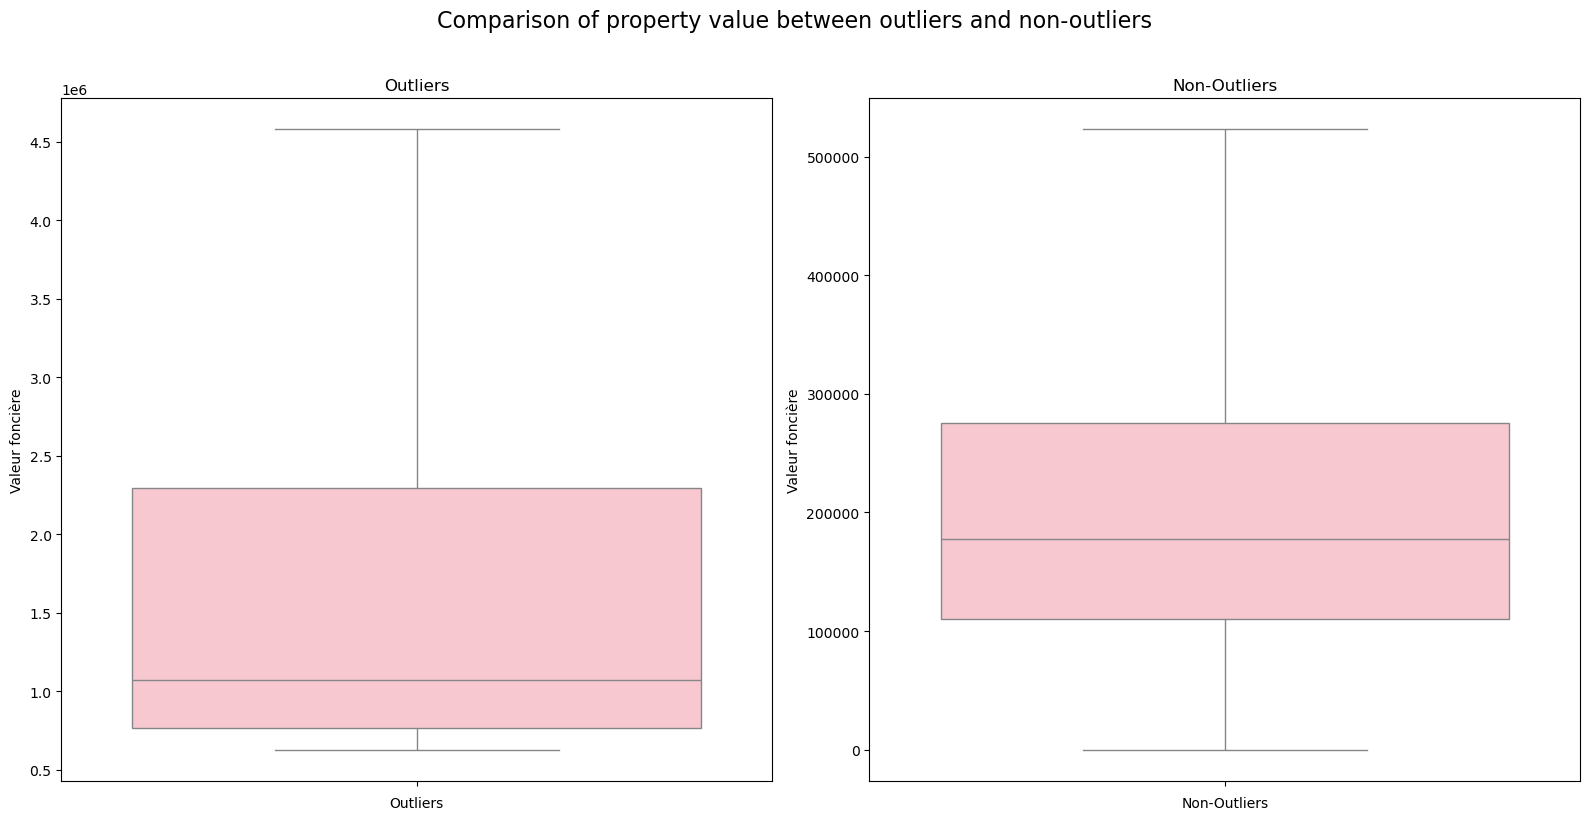

In [48]:
#### COMPARISON BW OUTLIERS AND NON-OUTLIERS ####
plt.figure(figsize=(16, 8))
plt.suptitle("Comparison of property value between outliers and non-outliers", fontsize=16, y=1.02)

# Outliers
plt.subplot(1, 2, 1)
sns.boxplot(y=outliers['Valeur fonciere'], color='pink', showfliers=False)
plt.title('Outliers')
plt.ylabel('Valeur foncière')
plt.xlabel('Outliers')

# Non-outliers
plt.subplot(1, 2, 2)
sns.boxplot(y=non_outliers['Valeur fonciere'], color='pink', showfliers=False)
plt.title('Non-Outliers')
plt.ylabel('Valeur foncière')
plt.xlabel('Non-Outliers')

plt.tight_layout()
plt.show()


We see that the outliers start at 500 000€, exactly where the non outliers stop, and they go up to 4 500 000€.

In [49]:
#### TYPE LOCAL COMPARISON BW OUTLIERS AND NON-OUTLIERS ####

colors = px.colors.qualitative.Pastel

# Count type local
outliers_tl_count = outliers['Type local'].value_counts()
non_outliers_tl_count = non_outliers['Type local'].value_counts()

# Subplots
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=("Outliers", "Non-Outliers"),
    specs=[[{"type": "pie"}, {"type": "pie"}]]
)

# Outliers
fig.add_trace(
    go.Pie(
    labels = outliers_tl_count.index,
    values = outliers_tl_count,
    name = 'Type local',
    marker = dict(colors = colors),
    ),
    row=1, col=1
)

# Non-outliers
fig.add_trace(
    go.Pie(
        labels = non_outliers_tl_count.index,
        values = non_outliers_tl_count,
        name = 'Type local',
        marker = dict(colors = colors),
    ),
    row=1, col=2
)

fig.update_layout(
    title_text="Comparison of local types between outliers and non-outliers",
    showlegend=True
)
fig.show()

We can see that the majority of local types are appartments then houses for both but for the outliers, the portion of industrial local is greater than for non outliers.

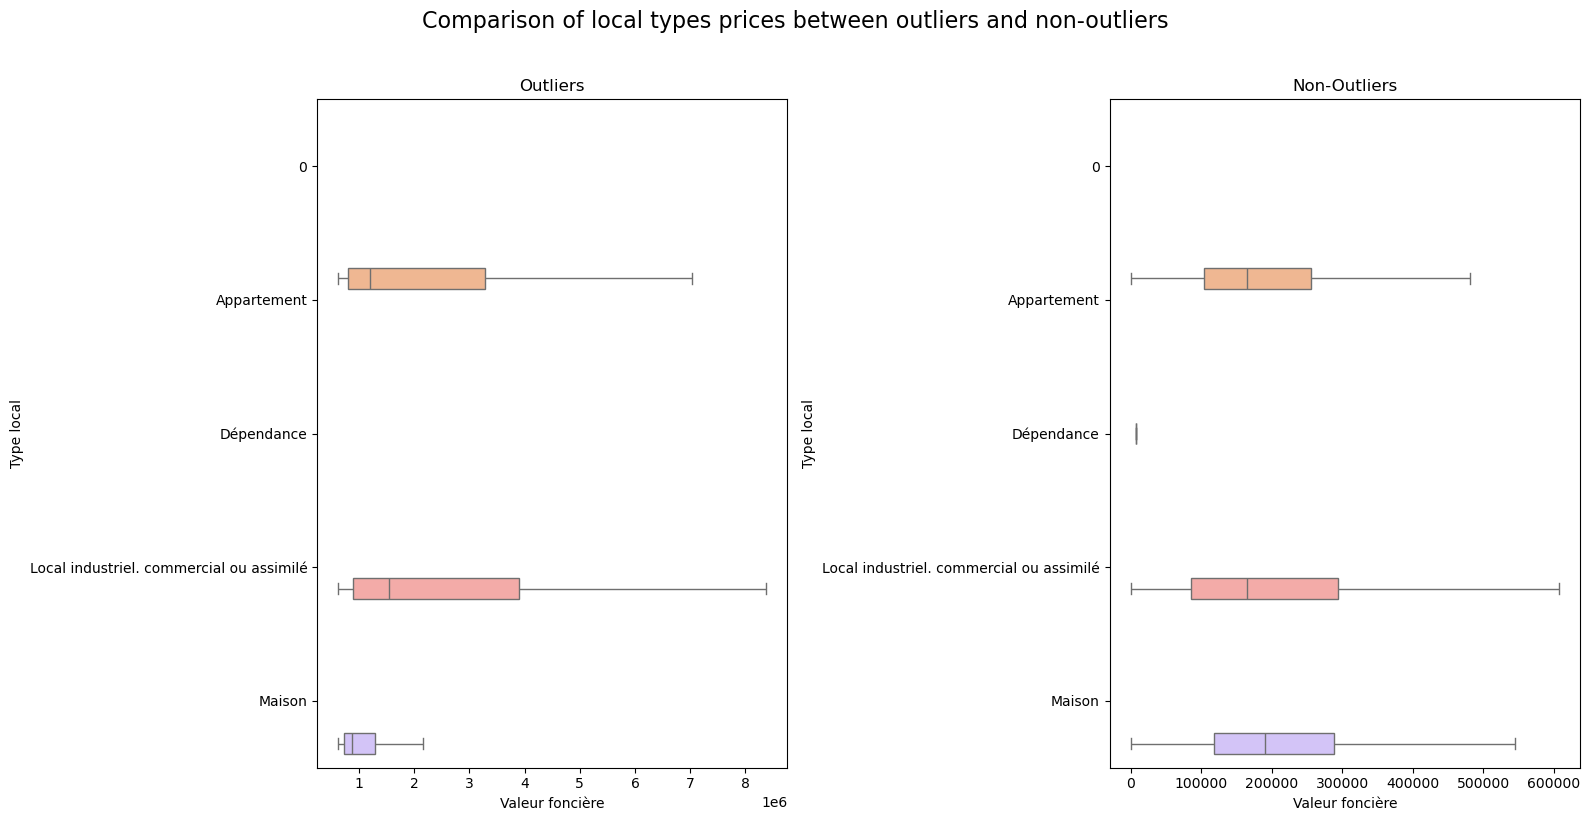

In [50]:
#### COMPARISON BW OUTLIERS AND NON-OUTLIERS ####
plt.figure(figsize=(16, 8))
plt.suptitle("Comparison of local types prices between outliers and non-outliers", fontsize=16, y=1.02)

# Outliers
plt.subplot(1, 2, 1)
sns.boxplot(x='Valeur fonciere', y='Type local', data=outliers, hue='Type local', palette='pastel', showfliers=False, dodge='False')
plt.title('Outliers')
plt.ylabel('Type local')
plt.xlabel('Valeur foncière')

# Non-outliers
plt.subplot(1, 2, 2)
sns.boxplot(x='Valeur fonciere', y='Type local', data=non_outliers, hue='Type local', palette='pastel', showfliers=False, dodge='False')
plt.title('Non-Outliers')
plt.ylabel('Type local')
plt.xlabel('Valeur foncière')

plt.tight_layout()
plt.show()


We can see that the proce range for apartments are from 1M€ to 7M€ for outliers and only up to 450 000€ for non-outliers.

Let's try to see which local types are the most sold by region.

In [51]:
#### DICTIONNARY TO ASSOCIATE EACH DEPARTMENT TO ITS REGION ####
departement_to_region = {
    # Auvergne-Rhône-Alpes
    1: 'Auvergne-Rhône-Alpes', 3: 'Auvergne-Rhône-Alpes', 7: 'Auvergne-Rhône-Alpes',
    15: 'Auvergne-Rhône-Alpes', 26: 'Auvergne-Rhône-Alpes', 38: 'Auvergne-Rhône-Alpes',
    42: 'Auvergne-Rhône-Alpes', 43: 'Auvergne-Rhône-Alpes', 63: 'Auvergne-Rhône-Alpes',
    69: 'Auvergne-Rhône-Alpes', 73: 'Auvergne-Rhône-Alpes', 74: 'Auvergne-Rhône-Alpes',
    
    # Bourgogne-Franche-Comté
    21: 'Bourgogne-Franche-Comté', 25: 'Bourgogne-Franche-Comté', 39: 'Bourgogne-Franche-Comté',
    58: 'Bourgogne-Franche-Comté', 70: 'Bourgogne-Franche-Comté', 71: 'Bourgogne-Franche-Comté',
    89: 'Bourgogne-Franche-Comté', 90: 'Bourgogne-Franche-Comté',
    
    # Bretagne
    22: 'Bretagne', 29: 'Bretagne', 35: 'Bretagne', 56: 'Bretagne',
    
    # Centre-Val de Loire
    18: 'Centre-Val de Loire', 28: 'Centre-Val de Loire', 36: 'Centre-Val de Loire',
    37: 'Centre-Val de Loire', 41: 'Centre-Val de Loire', 45: 'Centre-Val de Loire',
    
    # Corse
    2: 'Corse', 20: 'Corse',  '2A': 'Corse', '2B': 'Corse',
    
    # Grand Est
    8: 'Grand Est', 10: 'Grand Est', 51: 'Grand Est', 52: 'Grand Est',
    54: 'Grand Est', 55: 'Grand Est', 57: 'Grand Est', 67: 'Grand Est',
    68: 'Grand Est', 88: 'Grand Est',
    
    # Hauts-de-France
    2: 'Hauts-de-France', 59: 'Hauts-de-France', 60: 'Hauts-de-France',
    62: 'Hauts-de-France', 80: 'Hauts-de-France',
    
    # Île-de-France
    75: 'Île-de-France', 77: 'Île-de-France', 78: 'Île-de-France', 91: 'Île-de-France',
    92: 'Île-de-France', 93: 'Île-de-France', 94: 'Île-de-France', 95: 'Île-de-France',
    
    # Normandie
    14: 'Normandie', 27: 'Normandie', 50: 'Normandie', 61: 'Normandie', 76: 'Normandie',
    
    # Nouvelle-Aquitaine
    16: 'Nouvelle-Aquitaine', 17: 'Nouvelle-Aquitaine', 19: 'Nouvelle-Aquitaine',
    23: 'Nouvelle-Aquitaine', 24: 'Nouvelle-Aquitaine', 33: 'Nouvelle-Aquitaine',
    40: 'Nouvelle-Aquitaine', 47: 'Nouvelle-Aquitaine', 64: 'Nouvelle-Aquitaine',
    79: 'Nouvelle-Aquitaine', 86: 'Nouvelle-Aquitaine', 87: 'Nouvelle-Aquitaine',
    
    # Occitanie
    9: 'Occitanie', 11: 'Occitanie', 12: 'Occitanie', 30: 'Occitanie', 31: 'Occitanie',
    32: 'Occitanie', 34: 'Occitanie', 46: 'Occitanie', 48: 'Occitanie', 65: 'Occitanie',
    66: 'Occitanie', 81: 'Occitanie', 82: 'Occitanie',
    
    # Pays de la Loire
    44: 'Pays de la Loire', 49: 'Pays de la Loire', 53: 'Pays de la Loire',
    72: 'Pays de la Loire', 85: 'Pays de la Loire',
    
    # Provence-Alpes-Côte d'Azur
    4: 'Provence-Alpes-Côte d\'Azur', 5: 'Provence-Alpes-Côte d\'Azur',
    6: 'Provence-Alpes-Côte d\'Azur', 13: 'Provence-Alpes-Côte d\'Azur',
    83: 'Provence-Alpes-Côte d\'Azur', 84: 'Provence-Alpes-Côte d\'Azur',
    
    # DROM (Départements d'outre-mer)
    971: 'Guadeloupe', 972: 'Martinique', 973: 'Guyane', 974: 'La Réunion', 976: 'Mayotte'
}

grouped_geo ['region'] = grouped_geo['Code departement'].map(departement_to_region)
grouped_outliers['region'] = grouped_outliers['Code departement'].map(departement_to_region)
grouped_non_outliers['region'] = grouped_non_outliers['Code departement'].map(departement_to_region)

df_geo ['region'] = df_geo['Code departement'].map(departement_to_region)
outliers['region'] = outliers['Code departement'].map(departement_to_region)
non_outliers['region'] = non_outliers['Code departement'].map(departement_to_region)


/var/folders/ql/7rnwb81s5ms8q8f6v8hbbkb00000gn/T/ipykernel_1078/3937816774.py:69: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/ql/7rnwb81s5ms8q8f6v8hbbkb00000gn/T/ipykernel_1078/3937816774.py:70: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [52]:
#### DELETE ROWS WHERE 'REGION' IS NULL ####
df_geo.dropna(subset=['region'], inplace=True)
grouped_geo.dropna(subset=['region'], inplace=True)

outliers.dropna(subset=['region'], inplace=True)
grouped_outliers.dropna(subset=['region'], inplace=True)

non_outliers.dropna(subset=['region'], inplace=True)
grouped_non_outliers.dropna(subset=['region'], inplace=True)

outliers.isnull().sum()

/var/folders/ql/7rnwb81s5ms8q8f6v8hbbkb00000gn/T/ipykernel_1078/3637530224.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/ql/7rnwb81s5ms8q8f6v8hbbkb00000gn/T/ipykernel_1078/3637530224.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Date mutation                0
Nature mutation              0
Valeur fonciere              0
Voie                         0
Code postal                  0
Commune                      0
Code departement             0
Code commune                 0
Nombre de lots               0
Code type local              0
Type local                   0
Surface reelle bati          0
Nombre pieces principales    0
Surface terrain              0
annee                        0
price_per_sq_meter           0
region                       0
dtype: int64

In [53]:
grouped_non_outliers.head()

,Code departement,Commune,annee,Type local,Surface terrain,mean_outliers_value,median_outliers_value,sum_outliers_value,count_non_outliers_transactions,non_outliers_avg_price_per_sq_meter,region
0,1,ABERGEMENT-DE-VAREY (L ),2019,Maison,135.0,103650.0,103650.0,103650.0,1,2073.00,Auvergne-Rhône-Alpes
1,1,ABERGEMENT-DE-VAREY (L ),2019,Maison,390.0,102000.0,102000.0,102000.0,1,850.00,Auvergne-Rhône-Alpes
2,1,ABERGEMENT-DE-VAREY (L ),2019,Maison,408.0,70000.0,70000.0,70000.0,1,933.33,Auvergne-Rhône-Alpes
3,1,ABERGEMENT-DE-VAREY (L ),2019,Maison,647.0,304800.0,304800.0,304800.0,1,1319.48,Auvergne-Rhône-Alpes
4,1,ABERGEMENT-DE-VAREY (L ),2019,Maison,757.0,163000.0,163000.0,163000.0,1,1164.29,Auvergne-Rhône-Alpes


In [56]:
#### CHECK DUPLICATES ####
grouped_non_outliers.drop_duplicates(subset=['non_outliers_avg_price_per_sq_meter', 'Commune', 'Type local', 'annee', 'Surface terrain'],keep='last', inplace=True)
grouped_non_outliers.duplicated(subset=['non_outliers_avg_price_per_sq_meter', 'Commune', 'Type local', 'annee', 'Surface terrain']).sum()


0

In [59]:
#### CHECK DUPLICATES ####
grouped_geo.drop_duplicates(subset=['avg_price_per_sq_meter', 'Commune', 'Type local', 'annee', 'Surface terrain'],keep='last', inplace=True)
grouped_geo.duplicated(subset=['avg_price_per_sq_meter', 'Commune', 'Type local', 'annee', 'Surface terrain']).sum()


0

In [60]:
#### CHECK DUPLICATES ####
#grouped_outliers.drop_duplicates(subset=['avg_price_per_sq_meter', 'Commune', 'Type local', 'annee', 'Surface terrain'],keep='last', inplace=True)
grouped_outliers.duplicated(subset=['outliers_avg_price_per_sq_meter', 'Commune', 'Type local', 'annee', 'Surface terrain']).sum()


0

In [26]:
#### LOCAL TYPE BY REGION ####

def show_lt(annee):
    data_general=df_geo[df_geo['annee'] == annee]
    df_geo_sum = data_general.groupby(['region', 'Type local'], observed=True)['Type local'].count().unstack(fill_value=0)
    

    plt.figure(figsize=(18, 9))
    
    # General
    #plt.subplot(3, 1, 1)
    df_geo_sum.plot(kind='bar', stacked=True, figsize=(18, 9), colormap='Pastel1')
    #plt.ylim(0, 5000)
    plt.xticks(rotation=45)
    #plt.yticks(range(0, max_y + 500, 500))
    plt.title('General local type sold by region per year')
    plt.ylabel('Local type')
    plt.xlabel('Region')
    
    #plt.subplots_adjust(wspace=4)
    #plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Slider
widgets.interact(
    show_lt, 
    annee=widgets.IntSlider(
        min=df_geo['annee'].min(),
        max=df_geo['annee'].max(),
        step=1, 
        description='Year')
    )

interactive(children=(IntSlider(value=2019, description='Year', max=2024, min=2019), Output()), _dom_classes=(…

<function __main__.show_lt(annee)>

- The amount of sales varies alot along along the years. From a maximum of 100 000 local sold in 2019 to 200 000 in 2021 and 50 500 in 2024. 
- The most sales are always in Ile-de-France, Provence-Alpes-Cote-d'Azur and Auvergne-Rhone-Alpes but other regions also become popular over the years, such as Nouvvelle-Acquiitainr or Hauts-de-France. 
- The least amount of sales are pretty stable over the years and are located in the DOM TOMs and Corse.
- The most sold local types are appartments and houses alsmost equally then industrial as seen previously.

In [27]:
#### OUTLIERS LOCAL TYPE BY REGION ####

def show_lt(annee):
    data_outliers=grouped_outliers[grouped_outliers['annee'] == annee]
    grouped_outliers_sum = data_outliers.groupby(['region', 'Type local'], observed=True)['count_outliers_transactions'].sum().unstack(fill_value=0)
    
    plt.figure(figsize=(18, 9))
    
    # General
    #plt.subplot(3, 1, 1)
    grouped_outliers_sum.plot(kind='bar', stacked=True, figsize=(18, 9), colormap='Set3')
    #plt.ylim(0, 5000)
    plt.xticks(rotation=45)
    #plt.yticks(range(0, max_y + 500, 500))
    plt.title('Outliers local type sold by region per year')
    plt.ylabel('Number of local type')
    plt.xlabel('Region')
    
    #plt.subplots_adjust(wspace=4)
    #plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Slider
widgets.interact(
    show_lt, 
    annee=widgets.IntSlider(
        min=grouped_outliers['annee'].min(),
        max=grouped_outliers['annee'].max(),
        step=1, 
        description='Year')
    )

interactive(children=(IntSlider(value=2019, description='Year', max=2024, min=2019), Output()), _dom_classes=(…

<function __main__.show_lt(annee)>

- There are less sold locals in general among outliers since they are more expensive and the amount of sales is pretty stable along the years. From a maximum of 25 000 local sold in 2019 (only in Ile-de-France, the max is 8 000 outside of it) to 40 500 in 2021 (only in Ile-de-France, the max is 18 000 outside of it) and 12 500 in 2024 (only in Ile-de-France, the max is 7 000 outside of it). 
- The most sales are always in Ile-de-France by far (about twice as much), Provence-Alpes-Cote-d'Azur and Auvergne-Rhone-Alpes  
- The least amount of sales are in the DOM TOMs and are pretty stable along the years.
- The most sold local types are appartments then houses then industrial as seen previously.

In [74]:
#### NON-OUTLIERS LOCAL TYPE BY REGION ####

def show_lt(annee):
    data_non_outliers=grouped_non_outliers[grouped_non_outliers['annee'] == annee]
    grouped_non_outliers_sum = data_non_outliers.groupby(['region', 'Type local'], observed=True)['count_non_outliers_transactions'].sum().unstack(fill_value=0)
    
    plt.figure(figsize=(18, 9))
    
    # General
    #plt.subplot(3, 1, 1)
    grouped_non_outliers_sum.plot(kind='bar', stacked=True, figsize=(18, 9), colormap='Pastel2')
    #plt.ylim(0, 5000)
    plt.xticks(rotation=45)
    #plt.yticks(range(0, max_y + 500, 500))
    plt.title('Non-outliers local type sold by region per year')
    plt.ylabel('Number of local type')
    plt.xlabel('Region')
    
    #plt.subplots_adjust(wspace=4)
    #plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Slider
widgets.interact(
    show_lt, 
    annee=widgets.IntSlider(
        min=grouped_non_outliers['annee'].min(),
        max=grouped_non_outliers['annee'].max(),
        step=1, 
        description='Year')
    )

interactive(children=(IntSlider(value=2019, description='Year', max=2024, min=2019), Output()), _dom_classes=(…

<function __main__.show_lt(annee)>

- It is very similar to the general aspect, just slighly lower.
- The amount of sales varies alot along along the years. From a maximum of 100 000 local sold in 2019 to 190 000 in 2021 and 50 000 in 2024. 
- The most sales are always in Ile-de-France, Provence-Alpes-Cote-d'Azur and Auvergne-Rhone-Alpes but other regions also become popular over the years, such as Nouvelle-Acquitaine or Hauts-de-France. 
- The least amount of sales are pretty stable over the years and are located in the DOM TOMs annd Corse.
- The most sold local types are appartments and houses alsmost equally then industrial as seen previously.

Conclusion : 
- The general graph and the non-outliers graphs are almost identical !
- At least half of the outliers are sold in Ile-de-France.
- Not a lot of property are sold in the DOM TOMs.
- Most property ar sold in Ile-de-France, Provence-Alpes-Cote-d'Azur and Auvergne-Rhone-Alpes but other regions also become popular over the years, such as Nouvelle-Acquitaine or Hauts-de-France. 
- Almost half less property are sold than in 2019.
- The most sold local types are appartments then houses then industrial as seen previously with a larger portion of indstrial locals among outliers.


Now let's see the land surfaces by region per year.

In [77]:
#### GENERAL LAND SURFACE BY REGION ####

def show_lt(annee):
    data_general=grouped_geo[grouped_geo['annee'] == annee]
    grouped_geo_avg = data_general.groupby('region')['Surface terrain'].mean()
    
    plt.figure(figsize=(18, 9))
    
    # General
    #plt.subplot(3, 1, 1)
    grouped_geo_avg.plot(kind='bar', stacked=True, figsize=(18, 9), color='pink')
    #plt.ylim(0, 5000)
    plt.xticks(rotation=45)
    #plt.yticks(range(0, max_y + 500, 500))
    plt.title('General average land surface sold by region per year')
    plt.ylabel('Average land surface')
    plt.xlabel('Region')
    
    #plt.subplots_adjust(wspace=4)
    #plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Slider
widgets.interact(
    show_lt, 
    annee=widgets.IntSlider(
        min=grouped_geo['annee'].min(),
        max=grouped_geo['annee'].max(),
        step=1, 
        description='Year')
    )

interactive(children=(IntSlider(value=2019, description='Year', max=2024, min=2019), Output()), _dom_classes=(…

<function __main__.show_lt(annee)>

- The highest average land surface sold is Guyane by far with about 3 400m² in 2019. In 2020, it doubles up to 8 000m². However, in 2021 it drops to 2 000m² so it's closer to the others regions who have not changed a lot and it slithly rises in 2022 but it's about the same with 3 000m² and 4 000m² in 2023. It rises back up to 8 000m² in 2024.
- The rest of the regions stay around 1 000m².
- The lowest surface are usually Hauts-de-France and Grand-Est with about 500m².

In [30]:
#### OUTLIERS LAND SURFACE BY REGION ####

def show_lt(annee):
    data_outliers=grouped_outliers[grouped_outliers['annee'] == annee]
    grouped_outliers_avg = data_outliers.groupby('region')['Surface terrain'].mean()
    
    plt.figure(figsize=(18, 9))
    
    # General
    #plt.subplot(3, 1, 1)
    grouped_outliers_avg.plot(kind='bar', stacked=True, figsize=(18, 9), colormap='Set3')
    #plt.ylim(0, 5000)
    plt.xticks(rotation=45)
    #plt.yticks(range(0, max_y + 500, 500))
    plt.title('Outliers average land surface sold by region per year')
    plt.ylabel('Average land surface (in m²)')
    plt.xlabel('Region')
    
    #plt.subplots_adjust(wspace=4)
    #plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Slider
widgets.interact(
    show_lt, 
    annee=widgets.IntSlider(
        min=grouped_outliers['annee'].min(),
        max=grouped_outliers['annee'].max(),
        step=1, 
        description='Year')
    )

interactive(children=(IntSlider(value=2019, description='Year', max=2024, min=2019), Output()), _dom_classes=(…

<function __main__.show_lt(annee)>

- The highest average land surface sold is Grand-Est, Normandie, Centre-Val-de-Loire and Bourgogne-Franche-Comté with about 5 000m² in 2019. 
- In 2020, Guyane is up to 20 000m² while the others are between 2 500 and 5 000m². 
- However, in 2021 the highest are Normandie and Centre-Val-de-Loire at around 4 000m² while others are between 1 700m² and 3 000m². 
- In 2022, Guyane and Centre-Val-de-Loire are the highestat about 7 000 and Bourgogne-Franche-Comté, Grand-Est and Normandie are around 4 500m² while the others are at around 2 000m². 
- In 2023, Centre-Val-de-Loire is the highest 8 000m² and Martinique and Normandie at 5 000m² while the others are at around 2 500m². 
- In 2024, Guyane is by far the highest with 10 000m², then Centre-Val-de-Loire at 4 500m² while the others are at around 2 500m² .
- Most of the regions stay around 2 500m².
- The lowest surface is usually Ile-de-France and Grand-Est with about 1 000m².

In [67]:
#### NON-OUTLIERS LOCAL TYPE BY REGION ####

def show_lt(annee):
    data_non_outliers=grouped_non_outliers[grouped_non_outliers['annee'] == annee]
    grouped_non_outliers_avg = data_non_outliers.groupby('region')['Surface terrain'].mean()
    
    plt.figure(figsize=(18, 9))
    
    # General
    #plt.subplot(3, 1, 1)
    grouped_non_outliers_avg.plot(kind='bar', stacked=True, figsize=(18, 9), color='salmon')
    #plt.ylim(0, 5000)
    plt.xticks(rotation=45)
    #plt.yticks(range(0, max_y + 500, 500))
    plt.title('Non-outliers average land surface sold by region per year')
    plt.ylabel('Average land surface (in m²)')
    plt.xlabel('Region')
    
    #plt.subplots_adjust(wspace=4)
    #plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Slider
widgets.interact(
    show_lt, 
    annee=widgets.IntSlider(
        min=grouped_non_outliers['annee'].min(),
        max=grouped_non_outliers['annee'].max(),
        step=1, 
        description='Year')
    )

interactive(children=(IntSlider(value=2019, description='Year', max=2024, min=2019), Output()), _dom_classes=(…

<function __main__.show_lt(annee)>

- Very similar to the general.
- The highest average land surface sold is Guyane by far with about 3 400m² in 2019. In 2020, it rises up to 5 500m². However, in 2021 it drops to 2 000m² so it's closer to the others regions who have not changed a lot and it slithly rises in 2022 but it's about the same with 2 500m² and La Réunion rises at 2 000m². In 2023, Guyane is at 4 000m² and La Réunion lowers back to 1 000m² like the others. Guyane rises back up to 8 000m² in 2024 with Corse at 2 000m².
- The rest of the regions stay around 1 000m².
- The lowest surface are usually Hauts-de-France and Grand-Est with about 500m².

Conclusion : 
- The general graph and the non-outliers graphs are almost identical !
- Most land surfaces are around 2,500m² for outliers and 1,000m² for the others.
- The highest average land surface in general is Guyane.
- For outliers the highest average land surface are usually Grand-Est, Normandie, Centre-Val-de-Loire and Bourgogne-Franche-Comté as they are located in regions with big fields so there's a bigger capacity of building. From 2020 to now, Guyane is becoming a part of the highest.
- In general, the lowest land surfaces are Hauts-de-France and Grand-Est with about 500m².
- For outliers, it's Ile-de-France and Grand-Est with about 1,000m².
- In 2020, Guyane is by far the region with the most land surface sold (20,000m² / 5,500m²)



## Now let's study the number of sales per year per region.

In [32]:
#### GENERAL NUMBER OF SALES PER REGION PER YEAR ####

def show_data(annee):
    data_general=grouped_geo[grouped_geo['annee'] == annee]
   
    plt.figure(figsize=(18, 9))
    
    # General
    #plt.subplot(3, 1, 1)
    plt.bar(data_general['region'], data_general['count_transactions'], color='pink')
    #plt.ylim(0, 5000)
    plt.xticks(rotation=45)
    #plt.yticks(range(0, max_y + 500, 500))
    plt.title('General number of sales per region')
    plt.ylabel('Number of sales')
    plt.xlabel('Region')
    
    #plt.subplots_adjust(wspace=4)
    #plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Slider
widgets.interact(
    show_data, 
    annee=widgets.IntSlider(
        min=grouped_geo['annee'].min(),
        max=grouped_geo['annee'].max(),
        step=1, 
        description='Year')
    )

interactive(children=(IntSlider(value=2019, description='Year', max=2024, min=2019), Output()), _dom_classes=(…

<function __main__.show_data(annee)>

- In 2019, the highest is Provence-Alpes-Cote-d'Azur with 4,500 sales, followed by Occitanie, Pays de la Loire with 3,000 sales and Ile-de-France with 2,000 sales while the others are between 1,000 and 2,000 sales except for the DOM TOMs and Corse which are way lower around 250 to 500 sales.
- In 2020, Provence-Alpes-Cote-d'Azur and Occitanie are the highest with 9,500 sales and Pays de la Loire with 6,000 sales so it doubled while the rest is between 2,500 and 4,500 sales except for the DOM TOMs and Corse which are way lower around 250 to 2,000 sales for La Réunion.
- In 2021, Provence-Alpes-Cote-d'Azur and Occitanie are the highest with 8,500 sales and Pays de la Loire, Nouvelle-Acquitaine, Ile-de-France and Hauts-de-France with 4,500 sales so it lowered while the rest is around 3,000 sales except for the DOM TOMs and Corse which are way lower around 250 to 1,000 sales for La Réuinon.
- In 2022, Provence-Alpes-Cote-d'Azur and Occitanie are the highest with 10,000 sales and Pays de la Loire, Nouvelle-Acquitaine, Ile-de-France and Hauts-de-France with 4,500 sales so it stayed the same while the rest is around 3,000 sales except for the DOM TOMs and Corse which are way lower around 250 to 1,500 sales for La Réunion.
- In 2023, Provence-Alpes-Cote-d'Azur and Occitanie are the highest with 8,000 sales while the rest is between 3,000 and 4,500 sales except for the DOM TOMs and Corse which are way lower around 250 to 2,000 sales for La Réunion.
- In 2024, Provence-Alpes-Cote-d'Azur and Occitanie are the highest with 3,000 sales so it lowered considerably and Pays de la Loire, Nouvelle-Acquitaine and Ile-de-France with 1,500 sales so it lowered while the rest is around 1,000 sales except for the DOM TOMs and Corse which are way lower around 150 to 5000 sales for La Réunion.

- There huge drop of sales in 2024 because we are only studying one semester.


In [33]:
#### OUTLIERS NUMBER OF SALES PER REGION PER YEAR ####

def show_data(annee):
    data_outliers=grouped_outliers[grouped_outliers['annee'] == annee]
    
    plt.figure(figsize=(18, 9))

    # Outliers
    #plt.subplot(3, 1, 2)
    plt.bar(data_outliers['region'], data_outliers['count_outliers_transactions'], color='skyblue')
    #plt.ylim(0, 4000)
    plt.xticks(rotation=45)
    plt.title('Outliers number of sales per region')
    plt.ylabel('Number of sales')
    plt.xlabel('Region')
    
    #plt.subplots_adjust(wspace=4)
    #plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Slider
widgets.interact(
    show_data, 
    annee=widgets.IntSlider(
        min=grouped_outliers['annee'].min(),
        max=grouped_outliers['annee'].max(),
        step=1, 
        description='Year')
    )

interactive(children=(IntSlider(value=2019, description='Year', max=2024, min=2019), Output()), _dom_classes=(…

<function __main__.show_data(annee)>

- The highest amount of sales always occurs in Ile-de-France with a pic in 2021 and 2022 at 2,000 sales (usually around 1,600 sales). 
- In 2023, Provence-Alpes-Cote-d'Azur, Guadeloupe and Occitanie are around 1,250 sales.
- Bretagne, Nouvelle-Acquitaine and Provence-Alpes-Cote-d'Azur also have a pic these years at around 800 sales (usually around 550 sales). 
- The others also have a pic these years at around 500 sales (usually around 300 sales). 
- In 2023, they are between 200 annd 400 sales.
- The lowest are the DOM TOMs at around 100 sales except for La Réunion at around 400 sales throughout the years except in 2021 (100 sales).
- There huge drop of sales in 2024 because we are only studying one semester. Ile-de-France is still first with 650 sales then Provence-Alpes-Cote-d'Azur with around 300 sales and the rest around 100 sales.



In [34]:
#### NON-OUTLIERS NUMBER OF SALES PER REGION PER YEAR ####

def show_data(annee):
    data_non_outliers=grouped_non_outliers[grouped_non_outliers['annee'] == annee]
    
    plt.figure(figsize=(18, 9))

    # Non-outliers
    #plt.subplot(3, 1, 3)
    plt.bar(data_non_outliers['region'], data_non_outliers['count_non_outliers_transactions'], color='salmon')
    #plt.ylim(0,5000)
    plt.xticks(rotation=45)
    #plt.yticks(range(0, max_y + 500, 500))
    plt.title('Non-outliers number of sales per region')
    plt.ylabel('Number of sales')
    plt.xlabel('Region')
    
    #plt.subplots_adjust(wspace=4)
    #plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Slider
widgets.interact(
    show_data, 
    annee=widgets.IntSlider(
        min=grouped_non_outliers['annee'].min(),
        max=grouped_non_outliers['annee'].max(),
        step=1, 
        description='Year')
    )

interactive(children=(IntSlider(value=2019, description='Year', max=2024, min=2019), Output()), _dom_classes=(…

<function __main__.show_data(annee)>

- It follows the same schema as the general. 
- The highest is Provence-Alpes-Cote-d'Azur, followed by Occitanie, Pays de la Loire and Ile-de-France while the others are between 2,000 and 3,000 sales in general except for the DOM TOMs and Corse which are way lower.
- The amount of sales has doubled since 2019.

Conclusion : 
- 

## Now let's compare the prices betweeen outliers and non-outliers in function of where they are located :
- Run interactive_maps_geo.ipynb to see maps of the price per square meter by departments depending on if they're outliers or not.

- Run interactive_maps_geo.ipynb to see maps of the average price per square meter by region depending on if they're outliers or not.

## 4 - Conlusion and recommandations ##

Summary of discoveries and investment advice.

Conclusions:
- Identify regions with the highest or lowest property values.
- Spot any geographical anomalies in property prices.

Recommendations :
- Investment advice based on regions with strong growth or attractive prices.
- Suggestions on how to leverage geographical trends for better returns.

Regions with the highest property values : 
- region price surface local type nb of sales

Regions with the lowest property values : 
- region price surface local type